In [95]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pickle
import re
from typing import Tuple, DefaultDict, Dict, List, Optional
from tqdm import tqdm, trange

### Zadanie 1. (5p) 
W zadaniu tym masz napisać system, który bierze na wejściu (ztokenizowany) tekst w języku polskim, pozbawiony wielkich liter oraz polskich znaków diakrytycznych i wypisuje na wyjściu poprawny tekst w języku polskim. Zakładamy, że literka „ź” na wejściu jest reprezentowana przez „z” (a nie „x”). Liczymy dwie miary dokładności:

a) Dokładność polskawa, czyli liczba słów poprawnie zrekonstruowanych (modulo wielkość liter, której nie uwzględniamy w tej mierze) podzielona przez liczbę słów w ogóle

b) Dokładność pełna, czyli liczba słów poprawnie zrekonstruowanych podzielona przez liczbę słów (tu uwzględniamy zarówno ogonki jak i wielkość liter).

Ostatecznym wynikiem będzie średnia geometryczna tych liczb. W tym zadaniu sprawdzany jest poziom basic, to znaczy że prezentowane rozwiązanie powinno:
- rekonstruować stokenizowany tekst,
- wykorzystywać dane dotyczące unigramów z części uczącej korpusu,
- w jakiś sposób (dowolny sensowny) uwzględniać informacje o dłuższych ciągach słów.


In [96]:
corpus_count = defaultdict(int)
with open('data.nogit/polish_corpora.txt', 'r') as f:
    for _ in trange(1000000):
        row = f.readline()
        text = preprocess(row)
        for w in text.split():
            corpus_count[w] += 1

100%|██████████| 1000000/1000000 [00:21<00:00, 47372.26it/s]


In [66]:
def preprocess(text: str) -> str:
    text = re.sub('[^a-zA-ZęóąśłżźńĘÓĄŚŁŻŹŃ ]', '', text)
    text = re.sub(' +', ' ', text)
    return text.strip()

In [67]:
def tokenize(text: str) -> str:
    polish_chars_replacements = {'ę': 'e', 'ó': 'o', 'ą': 'a', 'ś': 's', 'ł': 'l', 'ż': 'z', 'ź': 'z', 'ń': 'n'}
    text = text.lower()
    for polish, replacement in polish_chars_replacements.items():
        text = text.replace(polish, replacement)
    return text

In [112]:
to_norm_bigrams = np.min(list(bigrams_count.values()))

In [132]:
def reconstruct_text(
    original: str, 
    corpora_counts: DefaultDict[str, int], 
    bigrams: DefaultDict[str, List[str]],
    bigram_count: DefaultDict[Tuple[str, str], float],
    tokenized_to_word_mapping: Dict[str, str],
) -> str:
    assert len(original) > 0
    reconstructed_words = []
    tokenized = tokenize(original)
    prev_word = None
    for tokenized_word in tokenized.split():
        word = reconstruct_word(prev_word, tokenized_word, corpora_counts, bigrams, bigram_count, tokenized_to_word_mapping)
        reconstructed_words.append(word)
        prev_word = tokenized_word
        
    # Start with a big letter
    first_word_list = list(reconstructed_words[0])
    first_word_list[0] = first_word_list[0].upper()
    reconstructed_words[0] = ''.join(first_word_list)
    return ' '.join(reconstructed_words)

alpha = 0.5
def reconstruct_word(
    prev_word: Optional[str],
    tokenized_word: str, 
    corpora_counts: DefaultDict[str, int], 
    bigrams: DefaultDict[str, List[str]],
    bigram_count: DefaultDict[Tuple[str, str], float],
    tokenized_to_word_mapping: DefaultDict[str, List[str]],
) -> str:
    if tokenized_word not in tokenized_to_word_mapping:
        return tokenized_word
    possible_words = tokenized_to_word_mapping[tokenized_word]
    
    if prev_word is not None and prev_word in bigrams:
        next_words = list(bigrams[prev_word].intersection(set(possible_words)))
        if len(next_words) > 0:
            probs = [(alpha * bigram_count[prev_word, w] * to_norm_bigrams) **0.75 + 
                     ((1-alpha) * corpora_counts[w]) ** 0.75 
                     for w in next_words]
            best_word = next_words[np.argmax(probs)]
            return best_word
    
    probs = [corpora_counts[w] for w in possible_words]
    best_word = possible_words[np.argmax(probs)]
    return best_word

In [114]:
def compute_similarity(original: str, reconstucted: str) -> float:
    similarities = [0, 0]
    for original_word, recontructed_word in zip(original.split(), reconstucted.split()):
        if original_word.lower() == recontructed_word.lower():
            similarities[0] += 1
            
            if original_word == recontructed_word:
                similarities[1] += 1
    
    number_of_words = original.count(' ') + 1
    return np.sqrt(np.prod(similarities)) / number_of_words
#     return similarities[0] / number_of_words

In [70]:
corpora_counts = pickle.load(open('data.nogit/corpora_counts.pkl', 'rb'))

In [71]:
saved = pickle.load(open('bigrams_saved.nogit/saved.pkl', 'rb'))

In [72]:
bigrams = saved['from_words']['bigrams']
bigrams_count = saved['from_words']['bigrams_count']

In [73]:
tokenized_to_word_mapping = defaultdict(list)
for word in tqdm(corpora_counts.keys()):
    tokenized_word = tokenize(word)
    tokenized_to_word_mapping[tokenized_word].append(word)

100%|██████████| 2980295/2980295 [01:06<00:00, 45063.15it/s] 


In [74]:
sentences = []
for corpus in ['prusa', 'orzeszkowej', 'sienkiewicza']:
    sentences.extend(open(f'data.nogit/korpus_{corpus}.txt', 'r').read().split('\n'))
preprocessed_sentences = list(filter(lambda sent: len(sent) > 0, [preprocess(sent) for sent in sentences]))

In [105]:
preprocessed_sentences[:10]

['Antek',
 'Antek urodził się we wsi nad Wisłą',
 'Wieś leżała w niewielkiej dolinie Od północy otaczały ją wzgórza spadziste porosłe sosnowym lasem a od południa wzgórza garbate zasypane leszczyną tarniną i głogiem Tam najgłośniej śpiewały ptaki i najczęściej chodziły wiejskie dzieci rwa orzechy albo wybiera gniazda',
 'Kiedyś stanął na środku wsi zdawało ci się że oba pasma gór biegną ku sobie ażeby zetkną się tam gdzie z rana wstaje czerwone słońce Ale było to złudzenie',
 'Za wsią bowiem ciągnęła się między wzgórzami dolina przecięta rzeczułką i przykryta zieloną łąką',
 'Tam pasano bydlątka i tam cienkonogie bociany chodziły polowa na żaby kukające wieczorami',
 'Od zachodu wieś miała tamę za tamą Wisłę a za Wisłą znowu wzgórza wapienne nagie',
 'Każdy chłopski dom szarą słomą pokryty miał ogródek a w ogródku śliwki węgierki spomiędzy których wida było komin sadzą uczerniony i pożarną drabinkę Drabiny te zaprowadzono nie od dawna a ludzie myśleli że one lepiej chroni będą chaty od

In [106]:
similarities = []
for sentence in tqdm(preprocessed_sentences[2:], position=0, leave=True):
    reconstructed_sentence = reconstruct_text(sentence, corpus_count, bigrams, bigrams_count, tokenized_to_word_mapping)
    similarity = compute_similarity(original=sentence, reconstucted=reconstructed_sentence)
    similarities.append(similarity)
    print(f'\t\t{similarity}\n{sentence}\n{reconstructed_sentence}\n')
    break

print(np.min(similarities), np.mean(similarities), np.max(similarities))

  0%|          | 0/17180 [00:00<?, ?it/s]

		0.9206766149755737
Wieś leżała w niewielkiej dolinie Od północy otaczały ją wzgórza spadziste porosłe sosnowym lasem a od południa wzgórza garbate zasypane leszczyną tarniną i głogiem Tam najgłośniej śpiewały ptaki i najczęściej chodziły wiejskie dzieci rwa orzechy albo wybiera gniazda
Wieś leżała w niewielkiej dolinie od północy otaczały ją wzgórza spadziste porosłe sosnowym lasem a od południa wzgórza garbate zasypane leszczyna tarnina i głogiem tam najgłośniej śpiewały ptaki i najczęściej chodziły wiejskie dzieci rwa orzechy albo wybiera gniazda

0.9206766149755737 0.9206766149755737 0.9206766149755737


### Zadanie 2. (3 + Xp) 
W tym zadaniu rozwiązać należy dokładnie ten sam problem, co w poprzednim zadaniu. Żeby zadanie było uznane za zrobione poprawnie, wynik Twojego programu (na zbiorze ewaluacyjnym), musi być wyższy niż K = 0.955. Dodatkowo, jeżeli wynik R Twojego programu będzie większy niż Y = 0.96, to za zadanie dostaniesz 4 × $\frac{R−Y}{1-Y}$ . Dodatkowa premia to 4 punkty za najlepszy program, 3 punkty za drugie miejsce, 2 punkty za trzecie i 1 punkt za czwarte (liczone we wszystkich grupach). Dozwolone jest korzystanie z korpusu PolEval (pierwszy milion wierszy), N-gramów NKJP oraz Morfologika. Zbiór testowy to kolejne 200 tysięcy wierszy korpusu PolEvala.

In [129]:
def create_validation_set():
    i = 0
    validation_set = []
    with open('data.nogit/polish_corpora.txt', 'r') as f:
        while i < 1e6+200000:
            row = f.readline()
            i += 1
            if i < 1e6:
                continue
            validation_set.append(row)
    validation_set = (' '.join(validation_set)).split('.')
    return validation_set

In [130]:
validation_set = create_validation_set()

In [133]:
alpha = 0
similarities = []
for sentence in tqdm(validation_set, position=0, leave=True):
    sentence = preprocess(sentence)
    if len(sentence) == 0:
        continue
    reconstructed_sentence = reconstruct_text(sentence, corpora_counts, bigrams, bigrams_count, tokenized_to_word_mapping)
    similarity = compute_similarity(original=sentence, reconstucted=reconstructed_sentence)
    similarities.append(similarity)
#     print(f'\t\t{similarity}\n{sentence}\n{reconstructed_sentence}\n')
#     break
np.mean(similarities)

100%|██████████| 200001/200001 [01:16<00:00, 2623.40it/s]


0.9106598472302138

### Zadanie 3. (4p) 
W zadaniu tym zajmiemy się omawianym na wykładzie ukrytym łańcuchem Markowa, na przykładzie nieuczciwego krupiera rzucającego kością. Przypominam zasady:
1. Krupier ma dwie kości, uczciwą i oszukaną.
2. Kość oszukana daje 6 oczek z p = 1/2, a pozostałe wyniki z p = 1/10
3. Krupier zmienia kość uczciwą na nieuczciwą z p1 = 0.04, a nieuczciwą na uczciwą z p2 = 0.05
4. Zaczynamy od uczciwej kości.

Napisz program, który dla danego ciągu rzutów (który musisz sam wygenerować) wypisuje ciąg stanów (u – kość uczciwa, n – kość nieuczciwa, długość rzędu 10000), w sposób maksymalizujący liczbę prawidłowo zgadniętych stanów. Rozwiąż to zadanie na dwa sposoby:
- Proponując heurystyczny algorytm decydujący na podstawie badania skupisk szóstek
- Implementując poprawny algorytm, bazujący na zmiennych α oraz β (zobacz wykład o HMM).

Wykonując eksperymenty, oszacuj poprawność działania obu algorytmów, mierzoną liczbą poprawnie zgadniętych stanów (podzieloną przez długość ciągu).

In [2]:
valid_probs = np.full(6, 1/6)
trick_probs = np.append(np.full(5, 1/10), 1/2)

In [3]:
valid_to_trick_change_prob = 0.04
trick_to_valid_change_prob = 0.05

In [19]:
def generate_series(length: int) -> Tuple[np.ndarray, np.ndarray]:
    uses_valid = True
    dice_series, labels = [], []
    for _ in range(length):
        labels.append(uses_valid)
        if uses_valid:
            dice = np.random.choice(6, p=valid_probs) + 1
            if np.random.random() < valid_to_trick_change_prob:
                uses_valid = False
        else:
            dice = np.random.choice(6, p=trick_probs) + 1
            if np.random.random() < trick_to_valid_change_prob:
                uses_valid = True
        dice_series.append(dice)
    return np.array(dice_series), np.array(labels)

In [46]:
length = 10000
dice_series, labels = generate_series(length=length)

In [90]:
def find_labels(dice_series: np.ndarray, min_mean_to_fake: int=0.54) -> np.ndarray:
    labels = np.ones_like(dice_series, dtype=bool)
    
    six_idxs = np.flatnonzero(dice_series == 6)
    for i, start_six_idx in tqdm(enumerate(six_idxs), total=len(six_idxs)):
        if start_six_idx == 0:
            continue
        for end_six_idx in six_idxs[i+1:]:
            if end_six_idx - start_six_idx < 4:
                continue
            subseries = dice_series[start_six_idx:end_six_idx+1]
            if np.mean(subseries == 6) > min_mean_to_fake:
                labels[start_six_idx:end_six_idx+1] = False
    return labels

In [92]:
found_labels = find_labels(dice_series)
print(np.mean(found_labels==labels))

100%|██████████| 3214/3214 [02:08<00:00, 25.00it/s] 

0.8124


<BarContainer object of 10000 artists>

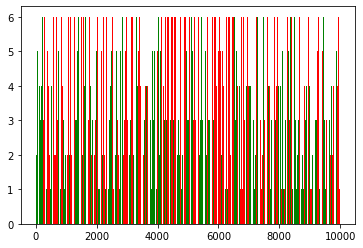

In [80]:
colors = np.where(labels == True, 'g', 'r')
plt.bar(np.arange(length), dice_series, color=colors)

<BarContainer object of 10000 artists>

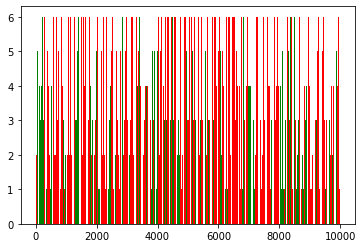

In [81]:
colors = np.where(found_labels == True, 'g', 'r')
plt.bar(np.arange(length), dice_series, color=colors)

### Zadanie 4. (4p) 
W tym zadaniu powinieneś zrekonstruować „parametry” krupiera. Mamy dwie sześcienne kości o nieznanych rozkładach (każdy rozkład to 6 liczb dodatnich, sumujących się do jedynki), zaczynamy od losowo wybranej kości1. Podobnie jak w poprzednim zadaniu p1 i p2 to prawdopodobieństwa zmiany kości. Na SKOSIe znajdziesz zestaw 20000 obserwacji (wyników rzutów kością), poczynionych dla tego modelu (ale do testów możesz też używać danych wygenerowanych w poprzednim zadaniu). Masz zrekonstruować model, uruchom Twój program dla kilku prefiksów dostępnych danych i porównaj wyniki.

Zastanów się, jak zainicjować model. Czy rozpoczynanie od równych prawdopodobieństw to dobry pomysł?